In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import os

from dataset import transform0, WR_fabini, FT_spectra
import matplotlib.pyplot as plt

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"
]

In [2]:
# --- Load models ---
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  

lat_dim = 9

dae_pred_trained_path = 'pretrained/{}_model_{}.pth'.format('dae', lat_dim)  
vae_pred_trained_path = 'pretrained/{}_model_{}.pth'.format('vae', lat_dim)  

dae = torch.load(dae_pred_trained_path)
vae = torch.load(vae_pred_trained_path)

dae.to(device)    
vae.to(device)    

dae.eval()
vae.eval()

SPV(
  (encoder): Sequential(
    (0): Down_Block(
      (CBR0): Conv_BN_LRelu(
        (layers): ModuleList(
          (0): Conv1d(1, 8, kernel_size=(3,), stride=(2,), padding=(1,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (CBR1): Conv_BN_LRelu(
        (layers): ModuleList(
          (0): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same)
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (short_down): Conv_BN(
        (layers): ModuleList(
          (0): Conv1d(1, 8, kernel_size=(3,), stride=(2,), padding=(1,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): Down_Block(
      (CBR0): Conv_BN_LRelu(
        (layers): ModuleList(
          (0): Conv1d(8, 16, kernel_siz

In [3]:
# --- Load datasets ---
data_path = 'datasets'

WR_train_x = WR_fabini(data_path, transform=transform0)
FT_train_x = FT_spectra(data_path, transform=transform0)

material_names = []
alphas_array = []
dae_lvs_array = []
vae_lvs_array = []
dae_reconstr_array = []
vae_reconstr_array = []
maxs_array = []
positions_array = []
nlm_array = []
slopes_array = []
slme_array = []

dataset = WR_train_x

for idx in range(dataset.__len__()//100+1):
    inputs = dataset.Spectra[100*idx:100*(idx+1), :]
    alphas_array.append(inputs)
    inputs = torch.from_numpy(inputs.astype(np.float32)).unsqueeze(1)
    
    dae_pred = dae(inputs.to(device))
    dae_recons = dae_pred[0]
    dae_z = dae_pred[2]

    vae_pred = vae(inputs.to(device))
    vae_recons = vae_pred[0]
    vae_z = vae_pred[2]
    
    dae_z = dae_z.detach().cpu().numpy()
    dae_recons = dae_recons.detach().cpu().numpy()
    dae_lvs_array.append(dae_z)
    dae_reconstr_array.append(dae_recons)
    
    vae_z = vae_z.detach().cpu().numpy()
    vae_recons = vae_recons.detach().cpu().numpy()
    vae_lvs_array.append(vae_z)
    vae_reconstr_array.append(vae_recons)    
    
    material_names.append(dataset.material_names[100*idx:100*(idx+1)])
    maxs_array.append(dataset.maxs_array[100*idx:100*(idx+1)])
    positions_array.append(dataset.positions_array[100*idx:100*(idx+1)])
    nlm_array.append(dataset.n_locals_array[100*idx:100*(idx+1)])
    slopes_array.append(dataset.slopes_array[100*idx:100*(idx+1)])
    slme_array.append(-1*np.ones_like(dataset.slopes_array[100*idx:100*(idx+1)]))
    
    
dataset = FT_train_x

for idx in range(dataset.__len__()//100+1):
    inputs = dataset.Spectra[100*idx:100*(idx+1), :]
    alphas_array.append(inputs)
    inputs = torch.from_numpy(inputs.astype(np.float32)).unsqueeze(1)
    
    dae_pred = dae(inputs.to(device))
    dae_recons = dae_pred[0]
    dae_z = dae_pred[2]

    vae_pred = vae(inputs.to(device))
    vae_recons = vae_pred[0]
    vae_z = vae_pred[2]
    
    dae_z = dae_z.detach().cpu().numpy()
    dae_recons = dae_recons.detach().cpu().numpy()
    dae_lvs_array.append(dae_z)
    dae_reconstr_array.append(dae_recons)
    
    vae_z = vae_z.detach().cpu().numpy()
    vae_recons = vae_recons.detach().cpu().numpy()
    vae_lvs_array.append(vae_z)
    vae_reconstr_array.append(vae_recons)    
    
    material_names.append(dataset.material_names[100*idx:100*(idx+1)])
    maxs_array.append(dataset.maxs_array[100*idx:100*(idx+1)])
    positions_array.append(dataset.positions_array[100*idx:100*(idx+1)])
    nlm_array.append(dataset.n_locals_array[100*idx:100*(idx+1)])
    slopes_array.append(dataset.slopes_array[100*idx:100*(idx+1)])
    slme_array.append(dataset.slmes_array[100*idx:100*(idx+1)])


material_names = np.concatenate(material_names)
alphas_array = np.concatenate(alphas_array)
dae_lvs_array = np.concatenate(dae_lvs_array)
vae_lvs_array = np.concatenate(vae_lvs_array)
dae_reconstr_array = np.concatenate(dae_reconstr_array)[:, 0, :]
vae_reconstr_array = np.concatenate(vae_reconstr_array)[:, 0, :]
maxs_array = np.concatenate(maxs_array)
positions_array = np.concatenate(positions_array)
nlm_array = np.concatenate(nlm_array)
slopes_array = np.concatenate(slopes_array)
slme_array = np.concatenate(slme_array)

In [4]:
# --- Fit PCA on training set ---
pca = PCA(n_components=9)
pca_lvs_array = pca.fit_transform(alphas_array)
pca_reconstr_array = pca.inverse_transform(pca_lvs_array)

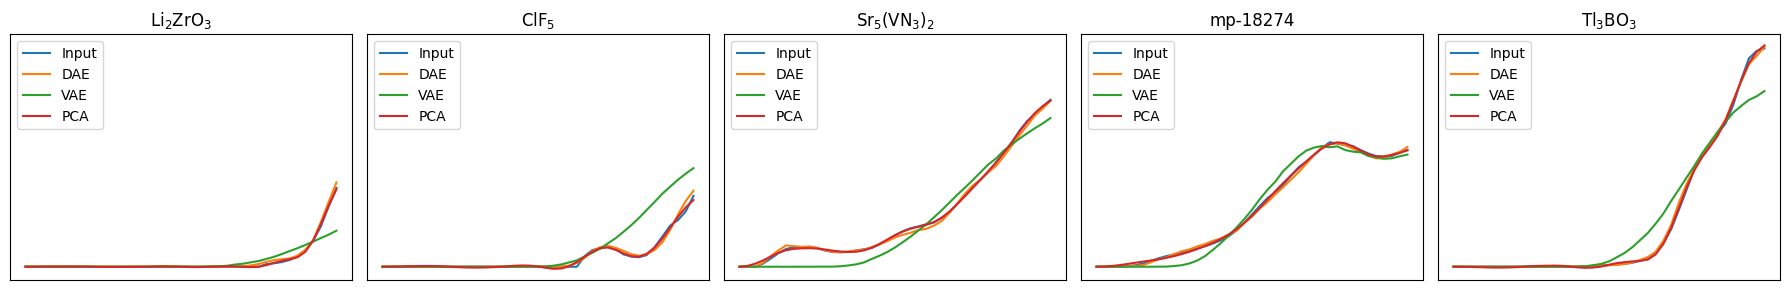

In [5]:
# --- Recon Compare ---
material_names = np.array(material_names)  # shape (N,)
target_names = ['mp-4156', 'mp-1213763', 'mp-1247227', 'mp-18274', 'mp-4584']
mpid_to_name = {
    'mp-4156': r'Li$_2$ZrO$_3$',       
    'mp-1213763': r'ClF$_5$',      
    'mp-1247227': r'Sr$_5$(VN$_3$)$_2$',      
    'mp-2201': r'PbSe',      
    'mp-4584': r'Tl$_3$BO$_3$'        
}


# Find indices for each target material
indices = [np.where(material_names == name)[0][0] for name in target_names]

fig, axs = plt.subplots(1, 5, figsize=(18, 3), sharey=True)

for ax, idx, mpid in zip(axs, indices, target_names):
    inputs = alphas_array[idx]
    dae_recon = dae_reconstr_array[idx]
    vae_recon = vae_reconstr_array[idx]
    pca_recon = pca_reconstr_array[idx]
    
    ax.plot(inputs, label='Input', c=colors[0])
    ax.plot(dae_recon, label='DAE', c=colors[1])
    ax.plot(vae_recon, label='VAE', c=colors[2])
    ax.plot(pca_recon, label='PCA', c=colors[3])
    # Use real/material name as the title
    ax.set_title(mpid_to_name.get(mpid, mpid))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [6]:
def pearson_correlation_matrix(X, Y):
    """Returns Pearson correlation coefficient matrix between X and Y."""
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    cov = Xc.T @ Yc / (X.shape[0] - 1)
    Xstd = Xc.std(axis=0, ddof=1)
    Ystd = Yc.std(axis=0, ddof=1)
    return cov / np.outer(Xstd, Ystd)

def plot_covariance_matrix(features, latents, feature_labels=None, lat_labels=None, title=None, savepath=None):
    """Visualises the covariance/correlation between features and latent dimensions."""
    covmat = pearson_correlation_matrix(features, latents)
    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.imshow(covmat, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)
    # Overlay correlation values
    for i in range(covmat.shape[0]):
        for j in range(covmat.shape[1]):
            ax.text(j, i, f'{covmat[i, j]:.2f}', ha='center', va='center', color='black')
    # Labels
    if feature_labels is not None:
        ax.set_yticks(range(len(feature_labels)))
        ax.set_yticklabels(feature_labels)
    else:
        ax.set_yticks([])
    if lat_labels is not None:
        ax.set_xticks(range(len(lat_labels)))
        ax.set_xticklabels(lat_labels, rotation=45)
    else:
        ax.set_xticks([])
    if title:
        ax.set_title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

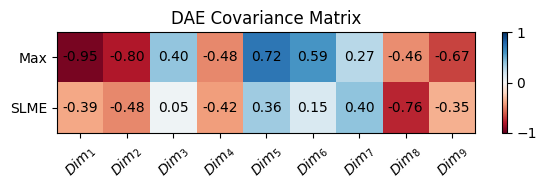

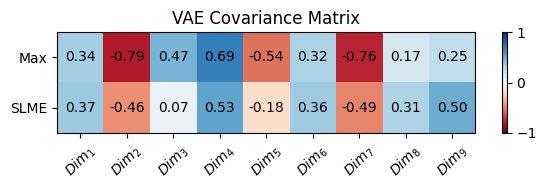

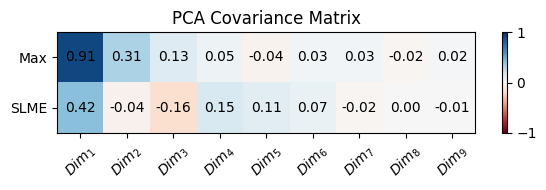

In [7]:
valid_idx = np.where(slme_array >= 0)[0]

features = np.concatenate((maxs_array[valid_idx].reshape(-1, 1), slme_array[valid_idx].reshape(-1, 1)), axis = 1)

plot_covariance_matrix(
    features,  dae_lvs_array[valid_idx],
    feature_labels=['Max', 'SLME'],
    lat_labels=[r'$Dim_{{{}}}$'.format(i+1) for i in range(dae_lvs_array.shape[1])],
    title='DAE Covariance Matrix'
)

plot_covariance_matrix(
    features,  vae_lvs_array[valid_idx],
    feature_labels=['Max', 'SLME'],
    lat_labels=[r'$Dim_{{{}}}$'.format(i+1) for i in range(vae_lvs_array.shape[1])],
    title='VAE Covariance Matrix'
)


plot_covariance_matrix(
    features,  pca_lvs_array[valid_idx],
    feature_labels=['Max', 'SLME'],
    lat_labels=[r'$Dim_{{{}}}$'.format(i+1) for i in range(pca_lvs_array.shape[1])],
    title='PCA Covariance Matrix'
)

In [8]:
def nearest_neighbor_search_(positions, ref_index, sorted_eff_indices, n):
    found_top_n = []
    count_top_n = 0

    for ii in range(len(positions)):
        if positions[ii] in sorted_eff_indices:
            count_top_n += 1
        found_top_n.append(count_top_n / n)  # Percentage of top n found

    
    return found_top_n

def process_data_(vec, material_names, ref_index):
    ref_vector = vec[ref_index].reshape(1, -1)
    metric = 'euclidean'#'euclidean'#'manhattan'
    vec_dist = pairwise_distances(vec, ref_vector, metric=metric).flatten()
    
    vec_dist = np.array(vec_dist)
    sorted_indices = np.argsort(vec_dist)
    positions = material_names[sorted_indices]
    return positions

def top_n_materials(mat_vecs, slmes_vecs, top_n):
    index_high_slme = np.argsort(slmes_vecs)[-1*top_n:][::-1]
    material_ids = mat_vecs[index_high_slme]
    
    material_idxs = []

    for id in material_ids:
        index = mat_vecs.tolist().index(id)
        material_idxs.append(index)

    return material_ids, material_idxs

def get_rate(lvs_array, mat_vecs, top_n_mat, ref_id, ref_idx, top_n):  
    positions = process_data_(lvs_array, mat_vecs, ref_idx)    
    result = nearest_neighbor_search_(positions, ref_id, top_n_mat, top_n)
    return result

In [9]:
unique_materials, unique_indices = np.unique(material_names, return_index=True)

mat_vecs_unique = material_names[unique_indices]
dae_vecs_unique = dae_lvs_array[unique_indices]
vae_vecs_unique = vae_lvs_array[unique_indices]
slmes_unique = slme_array[unique_indices]
pca = PCA(n_components=9)
pca_vecs_all = pca.fit_transform(alphas_array)
pca_vecs_unique = pca_vecs_all[unique_indices]

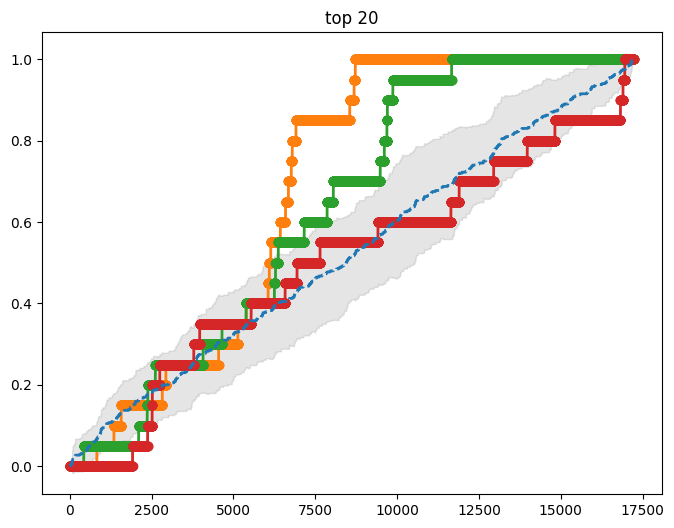

In [10]:
from sklearn.metrics import pairwise_distances

ref_id = 'mp-2534'
ref_idx = np.where(mat_vecs_unique == ref_id)[0]
top_n = 20

material_ids, material_idxs = top_n_materials(mat_vecs_unique, slmes_unique, top_n)

random_trials = 20
random_results = np.zeros((random_trials, len(dae_vecs_unique)))
for i in range(random_trials):
    sampled_indices = np.random.choice(len(dae_vecs_unique), len(dae_vecs_unique), replace=False)
    count_top_n = np.isin(sampled_indices, material_idxs).cumsum() / top_n
    random_results[i, :] = count_top_n

random_mean = random_results.mean(axis=0)
random_std = random_results.std(axis=0)

dae_vecs = dae_vecs_unique
vae_vecs = vae_vecs_unique
pca_vecs =pca_vecs_unique
    
dae_results = get_rate(dae_vecs, mat_vecs_unique, material_ids, ref_id, ref_idx, top_n)
vae_results = get_rate(vae_vecs, mat_vecs_unique, material_ids, ref_id, ref_idx, top_n)
pca_results = get_rate(pca_vecs, mat_vecs_unique, material_ids, ref_id, ref_idx, top_n)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(1, len(dae_results) + 1), dae_results, label="DAE", marker='o', color=colors[1], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), vae_results, label="VAE", marker='o', color=colors[2], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), pca_results, label="PCA", marker='o', color=colors[3], markersize=6, lw=2)
ax.plot(range(1, len(dae_results) + 1), random_mean, label="Random Sampling", linestyle='dashed', color=colors[0], lw=2)
ax.fill_between(range(1, len(dae_results) + 1), random_mean - random_std, random_mean + random_std, color='gray', alpha=0.2, label="Random Sampling Â±1 std")
# plt.xlabel("Number of Points Investigated")
# plt.ylabel(f"Fraction of Top {top_n} Efficiencies Found")
# plt.legend()
# ax.set_xticklabels([])
# ax.set_yticklabels([])
plt.title(f"top {top_n}")
# plt.savefig('efficiency_search.png', dpi=500)
plt.show()